In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import math
import re

In [2]:
tmean = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/tmean_prism_pennsylvania_data_1990_2023.csv')
ppt = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/ppt_prism_pennsylvania_data_1990_2023.csv')
#forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/foraging_quality_pennsylvania_data.csv')
forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/data/forage.csv')

cols = tmean.columns.tolist()

# create new columns 
new_cols = []
for col in cols:
    if "Forage" in col:
        code = col.split("_")[1]
        number = re.findall(r'\d+', code)[0]
        new_cols.append(number)
    else:
        new_cols.append(col)

new_cols

# rename columns
tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))

# create grid_id column
tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

possible_cols = tmean.col.tolist()
possible_rows = tmean.row.tolist()

forage["grid_id"] = forage["col"].astype(str) + "_" + forage["row"].astype(str)

def getGridForageQuality(col, row, year, forage=forage):
    grid_id = str(col) + "_" + str(row)
    try:
        return forage.query(f" grid_id == '{grid_id}' and year == {year}")['Forage_spring_1km'].values[0]
    except:
        return getGridForageQuality(col, row, year + 1)


def getGridForageQuality_vectorized(cols, rows, years,forage=forage):
    # Ensure grid_id is available in the forage DataFrame
    grid_ids = str(cols) + "_" + str(rows)

    # Match grid_id and year across entire DataFrame without looping
    mask = (forage['grid_id'].isin(grid_ids)) & (forage['year'].isin(years))

    # Extract the corresponding forage quality values
    forage_quality = forage.loc[mask, 'Forage_spring_1km']

    return forage_quality

################# tmean data #################

cols = tmean.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_tmean" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)
new_cols

tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))


tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

def getTmean(col, row, day, month, year, tmean=tmean):
    '''
    Get temperature data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    tmean: pd.DataFrame, temperature data

    output:
    float, temperature in degrees celcius
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    tmean = tmean[tmean["grid_id"] == grid_id][date].values[0]
    return tmean

############### ppt data #################

cols = ppt.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_ppt" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)

ppt = ppt.rename(columns=dict(zip(ppt.columns, new_cols)))

ppt["grid_id"] = ppt["col"].astype(str) + "_" + ppt["row"].astype(str)

def getPpt(col, row, day, month, year, ppt=ppt):
    '''
    Get precipitation data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    ppt: pd.DataFrame, precipitation data

    output:
    float, precipitation in mm
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    ppt = ppt[ppt["grid_id"] == grid_id][date].values[0]
    return ppt

In [3]:
################ Modeling ################

In [4]:
#grids = pd.read_csv('/Users/edwardamoah/Documents/Dissertation/Osmia_Pop_Simulation/pennsylvania_prism_grid_points_centre_county.csv')
#grids["grid_id"] = grids["col"].astype(str) + "_" + grids["row"].astype(str)
#grids = grids[["col", "row", "grid_id"]]
#grids

In [5]:
### create a function to get the tmean data between a dates 

# this is the extraction of tmean to calculate emergence for 2023

prepareTmean_dict = {}
def prepareEmergenceTmean(year, tmean=tmean):
    '''
    Prepare tmean for a given year for emergence calculation

    it return the data for tmean from November of the previous year to December of the current year
    '''

    if year in prepareTmean_dict:
        return prepareTmean_dict[year]
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    tmean_11 = tmean_copy.filter(like=f"year_{year-1}11")
    tmean_11['grid_id'] = tmean['grid_id']
    tmean_12 = tmean_copy.filter(like=f"year_{year-1}12")
    tmean_12['grid_id'] = tmean['grid_id']
    tmean_year = tmean_copy.filter(like=f"year_{year}")
    tmean_year['grid_id'] = tmean['grid_id']

    tmean_merge = pd.merge(tmean_11, tmean_12, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_year, on='grid_id')

    #tmean_merge = tmean_year # remove the 11 and 12 months data

    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    prepareTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [6]:
def getEmergence_vector(col, row, year):
    
    dev_threshold = 6.53
    cumulative_threshold = 209

    tmean_merge = prepareEmergenceTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_2 = arr_1 - dev_threshold
    arr_3 = np.where(arr_2 < 0, 0, arr_2)
    arr_4 = arr_3.cumsum()
    first_element_index = np.argwhere(arr_4 > cumulative_threshold)[0][0]

    emergence = datetime(year-1,11,1) + timedelta(days= int(first_element_index) + 1)
    #emergence = datetime(year,1,1) + timedelta(days= int(first_element_index) + 1)
    return datetime.fromtimestamp(emergence.timestamp())
    #return emergence#.strftime("%Y-%m-%d")

In [7]:
preWinterTmean_dict = {}
def preparePreWinterTmean(year):
    if year in preWinterTmean_dict:
        return preWinterTmean_dict[year]
    
    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for september and october
    tmean_09 = tmean_copy.filter(like=f"year_{year}09")
    tmean_09['grid_id'] = tmean['grid_id']
    tmean_10 = tmean_copy.filter(like=f"year_{year}10")
    tmean_10['grid_id'] = tmean['grid_id']

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_09, tmean_10, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    preWinterTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [8]:
def getPreWinteringMortality_vector(col, row, year, pre_winter_delta=0.0025):

    #dev_threshold = 6.53
    dev_threshold = 15

    tmean_merge = preparePreWinterTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_2 = arr_1 - dev_threshold
    arr_3 = np.where(arr_2 < 0, 0, arr_2)
   
    count = np.count_nonzero(arr_3 > 0)


    return {
        "mortality": count * pre_winter_delta,
        "dev_days": count,
        "cumulative_degrees": np.sum(arr_3)
    }


In [9]:
# prepare winter temperature data
winterTmean_dict = {}
def prepareWinterTmean(year):
    if year in winterTmean_dict:
        return winterTmean_dict[year]

    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for November, December and January to June of the next year
    tmean_11 = tmean_copy.filter(like=f"year_{year}11")
    tmean_11['grid_id'] = tmean['grid_id']
    tmean_12 = tmean_copy.filter(like=f"year_{year}12")
    tmean_12['grid_id'] = tmean['grid_id']
    tmean_01 = tmean_copy.filter(like=f"year_{year+1}01")
    tmean_01['grid_id'] = tmean['grid_id']
    tmean_02 = tmean_copy.filter(like=f"year_{year+1}02")
    tmean_02['grid_id'] = tmean['grid_id']
    tmean_03 = tmean_copy.filter(like=f"year_{year+1}03")
    tmean_03['grid_id'] = tmean['grid_id']
    tmean_04 = tmean_copy.filter(like=f"year_{year+1}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year+1}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year+1}06")
    tmean_06['grid_id'] = tmean['grid_id']

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_11, tmean_12, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_01, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_02, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_03, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_04, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')


    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    winterTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [10]:
def getWinteringTemperature_vector(col,row, year):
    dev_threshold = 6.53
    tmean_merge = prepareWinterTmean(year)
    arr_1 =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    #winter_temp = np.mean(arr_1)

    # filter for the days between November 1 and emergence date
    emergence = getEmergence_vector(col, row, year+1)
    #print(emergence)
    winter_date = datetime(year, 11, 1)
    temps = arr_1[:((emergence - winter_date).days)].tolist()
    winter_temp = np.mean(temps)
    
    if winter_temp > dev_threshold:
        return {
            "winter_temp": winter_temp,
            "mortality": 0.5,
            "temps": temps
        }
    else:
        return {
            "winter_temp": winter_temp,
            "mortality": 0,
            "temps": temps
        }


In [11]:
# prepare winter temperature data
reproductionTmean_dict = {}
def prepareReproductionTmean(year):
    if year in reproductionTmean_dict:
        return reproductionTmean_dict[year]
    
    # copy and rename columns
    tmean_copy = tmean.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for April, May and June
    tmean_04 = tmean_copy.filter(like=f"year_{year}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year}06")
    tmean_06['grid_id'] = tmean['grid_id']
    tmean_07 = tmean_copy.filter(like=f"year_{year}07")
    tmean_07['grid_id'] = tmean['grid_id']

    

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_04, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_07, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    reproductionTmean_dict[year] = tmean_merge
    
    return tmean_merge

In [12]:
# prepare winter temperature data
reproductionPpt_dict = {}
def prepareReproductionPpt(year):
    if year in reproductionPpt_dict:
        return reproductionPpt_dict[year]
    
    # copy and rename columns
    tmean_copy = ppt.copy()
    cols_c =  tmean_copy.columns.tolist()[5:]
    cols_c_n = [f"year_{col}" for col in cols_c]
    cols_c_n_d = dict(zip(cols_c, cols_c_n))
    tmean_copy.rename(columns=cols_c_n_d, inplace=True)

    # filter for April, May and June
    tmean_04 = tmean_copy.filter(like=f"year_{year}04")
    tmean_04['grid_id'] = tmean['grid_id']
    tmean_05 = tmean_copy.filter(like=f"year_{year}05")
    tmean_05['grid_id'] = tmean['grid_id']
    tmean_06 = tmean_copy.filter(like=f"year_{year}06")
    tmean_06['grid_id'] = tmean['grid_id']
    

    # merge the two dataframes
    tmean_merge = pd.merge(tmean_04, tmean_05, on='grid_id')
    tmean_merge = pd.merge(tmean_merge, tmean_06, on='grid_id')

    # add col, row and grid_id columns
    tmean_merge['col'] = tmean['col']
    tmean_merge['row'] = tmean['row']
    #tmean_merge['grid_id'] = tmean['grid_id']

    # make sure columns are in the right order
    tmean_merge = tmean_merge[sorted(tmean_merge.columns.tolist())]

    reproductionPpt_dict[year] = tmean_merge
    
    return tmean_merge

In [13]:
# define vectorize reproduction function

def getSpatiallyExplicitReproduction_vector(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold=0.5):

    starting_date = emergence + timedelta(days=mating_days)

    data_start = datetime(emergence.year, 4, 1)

    forage_quality = getGridForageQuality(col, row, emergence.year)
    if forage_quality < forage_threshold:
        egg_delta = 1
    else:
        egg_delta = 2

    # prepare temperature data
    tmean_merge = prepareReproductionTmean(emergence.year)
    arr_t =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_t1 = arr_t[(emergence - data_start).days + mating_days: (emergence - data_start).days + (longevity)]
    arr_t2 = np.where(arr_t1 >= temperature_threshold, 1, 0)

    # prepare precipitation data
    ppt_merge = prepareReproductionPpt(emergence.year)
    arr_p =  ppt_merge[(ppt_merge['col'] == col) & (ppt_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    arr_p1 = arr_p[(emergence - data_start).days + mating_days: (emergence - data_start).days + (longevity)]
    arr_p2 = np.where(arr_p1 < precipitation_threshold, 1, 0)


    arr_c = arr_t2 & arr_p2

    arr_c.sum()

    eggs = arr_c.sum() * egg_delta
    non_foraging_days = (longevity - mating_days) - arr_c.sum()
    precipitation_effect = (longevity - mating_days) - arr_p2.sum()
    temperature_effect = (longevity - mating_days) - arr_t2.sum()
    temps = arr_t1.tolist()
    ppts = arr_p1.tolist()

    egg_days = []
    for i in range(len(arr_c)):
        if arr_c[i] == 1:
            egg_days.append((starting_date + timedelta(days=i)).strftime("%Y-%m-%d")) 

    return {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts,
        "egg_days": egg_days,
        'forage_quality': forage_quality
    }


In [14]:
def getEggLarvaMortality_vector(col, row, emergence, reproduction):
    ldt = 10
    udt = 30
    egg_larva_days = 18
    mortality_delta = 0.1
    tmean_merge = prepareReproductionTmean(emergence.year)
    arr_t =  tmean_merge[(tmean_merge['col'] == col) & (tmean_merge['row'] == row)].filter(like="year").to_numpy().flatten()
    data_start = datetime(emergence.year, 4, 1)

    cold_days = []
    hot_days = []
    mortality = []
    for date in reproduction['egg_days']:
        date = datetime.strptime(date, "%Y-%m-%d")
        arr_t1 = arr_t[(date - data_start).days: (date - data_start).days + egg_larva_days]
        arr_t2_h = np.where((arr_t1 <= udt), 0, 1)
        arr_t2_c = np.where((arr_t1 >= ldt) , 0, 1)
        cold_days.append(arr_t2_c.sum())
        hot_days.append(arr_t2_h.sum())
        mortality.append((arr_t2_c.sum() + arr_t2_h.sum()) * mortality_delta)

    mortality = np.mean(mortality)
    if mortality > 1:
        mortality = 1
    
    if len(hot_days) == 0:
        return {
            "mortality": 0,
            "cold_days": 0,
            "hot_days": 0
        }


    return {
        "cold_days": np.mean(cold_days),
        "hot_days": np.mean(hot_days),
        "mortality": mortality
    }


In [15]:
# Emergence Model
import datetime
from datetime import datetime, timedelta

emergence_dict = {}

def getEmergence(col, row, year):
    '''
    Get emergence date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year

    output:
    datetime.date, emergence date
    '''

    dict_key = str(col) + "_" + str(row) + "_" + str(year)
    if dict_key in emergence_dict:
        return emergence_dict[dict_key]

    # function constants
    thermal_temp = 209 # adam et al
    dev_temp = 6.53 # adam et al


    starting_date = f"{year-1}-11-01" # November 1st of the previous year
    starting_date = datetime.strptime(starting_date, "%Y-%m-%d").date()
    cumulative_degrees = 0.0
    new_date = starting_date

    # determine emergence date
    cumulative_degrees = 0.0
    dev_list = []
    while cumulative_degrees < thermal_temp:
        daily_tmean = getTmean(col, row, new_date.day, new_date.month, new_date.year)
        try:
            if daily_tmean >= dev_temp:
                cumulative_degrees += float(daily_tmean - dev_temp)
                dev_list.append(float(daily_tmean - dev_temp))
            else:
                dev_list.append(0.0)
        except:
            print(col, row, new_date, daily_tmean)
            

        new_date += timedelta(days=1)

    emergence_dict[dict_key] = new_date

    return new_date #, dev_list

In [16]:
# Reproduction Model

reproductive_dict = {}

def getSpatiallyExplicitReproduction(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold=0.5):
    '''
    Get reproduction date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year
    emergence: datetime.date, emergence date

    output:
    datetime.date, reproduction date
    '''

    dict_key = str(col) + "_" + str(row) + "_" + emergence.strftime("%Y-%m-%d")
    if dict_key in reproductive_dict:
        return reproductive_dict[dict_key]

    # function constants
    eggs = 0
    egg_delta = 1 # change in eggs per day
     # update starting date
    starting_date = emergence + timedelta(days=mating_days)

    # update egg_delta based on foraging quality
    forage_quality = getGridForageQuality(col, row, starting_date.year)
    if forage_quality < forage_threshold:
        egg_delta = 1
    else:
        egg_delta = 2

    non_foraging_days = 0
    precipitation_effect = 0
    temperature_effect = 0
    temps = []
    ppts = []
    egg_days = []
    
    for i in range(longevity-mating_days):
        # get daily temperature and precipitation
        daily_tmean = getTmean(col, row, starting_date.day, starting_date.month, starting_date.year)
        daily_ppt = getPpt(col, row, starting_date.day, starting_date.month, starting_date.year)

        temps.append(daily_tmean)
        ppts.append(daily_ppt)

        # update eggs
        if daily_tmean >= temperature_threshold and daily_ppt < precipitation_threshold:
            eggs += egg_delta
            egg_days.append(starting_date.strftime("%Y-%m-%d"))
            
        else:
            non_foraging_days += 1
            if daily_tmean < temperature_threshold:
                temperature_effect += 1
            if daily_ppt >= precipitation_threshold:
                precipitation_effect += 1

        # update date
        starting_date += timedelta(days=1)
        

    return_dict = {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts,
        "egg_days": egg_days,
        'forage_quality': forage_quality
    }

    reproductive_dict[dict_key] = return_dict

    return return_dict

In [17]:
# Egg and Larva Mortality Model

def getEggLarvaMortality(col, row, emergence, reproduction, mating_days=2):

    def getEggMortalityProbability(date, tmeans, mortality_delta = 0.1):
        # constants
        ldt = 10 # c
        udt = 30 # c

        prob = 0
        cold_days = 0
        hot_days = 0
        for i in range(18): # 4 egg + 14 larva
            if tmeans[date] < ldt or tmeans[date] > udt:
                prob += mortality_delta
                if tmeans[date] < ldt:
                    cold_days += 1
                if tmeans[date] > udt:
                    hot_days += 1
            date = datetime.strptime(date, "%Y-%m-%d").date()
            date += timedelta(days=1)
            date = date.strftime("%Y-%m-%d")

            

        return {
            "prob": prob,
            "cold_days": cold_days,
            "hot_days": hot_days
        }

    total_dev_days = 38 # days 20 forages + 4 egg + 14 larva

    startdate = emergence + timedelta(days=mating_days)

    tmeans = {}
    for i in range(total_dev_days): # get all the tmeans

        tmeans[startdate.strftime("%Y-%m-%d")] = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        startdate += timedelta(days=1)

    egg_mortalities = []
    cold_days = []
    hot_days = []
    for egg_day in reproduction['egg_days']:
        mortality = getEggMortalityProbability(egg_day, tmeans)
        egg_mortalities.append(mortality['prob'])
        cold_days.append(mortality['cold_days'])
        hot_days.append(mortality['hot_days'])

    egg_mortalities = np.mean(egg_mortalities)
    if egg_mortalities > 1:
        egg_mortalities = 1


    if len(hot_days) == 0:
        return {
            "mortality": 0,
            "cold_days": 0,
            "hot_days": 0
        }

    return {    
        "mortality": egg_mortalities,
        "cold_days": np.mean(cold_days),
        "hot_days": np.mean(hot_days)
    }


In [18]:
# Pre-wintering Mortality Model

def getPreWinteringMortality(col, row, year, pre_winter_delta=0.0025):

    startdate = datetime(year, 9, 1)
    enddate = datetime(year, 11, 1)

    #dev_temp = 6.53
    dev_temp = 15

    mortality = 0
    dev_days = 0
    cumulative_degrees = 0
    
    while startdate < enddate:
        daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        if daily_tmean > dev_temp:
            mortality += pre_winter_delta
            dev_days += 1
            cumulative_degrees += float(daily_tmean - dev_temp)

        startdate += timedelta(days=1)

    return {
        "mortality": mortality,
        "dev_days": dev_days,
        "cumulative_degrees": cumulative_degrees
    }
    

In [19]:
# Wintering Mortality Model

def getWinteringTemperature(col, row, year):
        
        dev_temp = 6.53
    
        startdate = datetime(year, 11, 1)
        #enddate = datetime(year+1, 2, 1)
        try:
            enddate = getEmergence(col, row, year+1)
            enddate = datetime(enddate.year, enddate.month, enddate.day)
        except:
            enddate = datetime(year+1, 2, 1)

        print(enddate)

        temps = []
    
        while startdate < enddate:
            daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
            temps.append(daily_tmean)
    
            startdate += timedelta(days=1)
        
        winter_temp = np.mean(temps)

        if winter_temp > dev_temp:
            return {
                "winter_temp": winter_temp,
                "mortality": 0.5,
                "temps" : temps
            }
        else:
            return {
                "winter_temp": winter_temp,
                "mortality": 0,
                "temps" : temps
            }

In [20]:
######################## Run Simulation ################

In [21]:
#years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
#years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
years = [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
#years = [2020, 2021, 2022, 2023]
#years = [2016, 2017, 2018, 2019]

In [22]:
grids = tmean[["col","row","grid_id"]]

In [23]:
def getEmergenceData(col, row, year):
    try:
      return getEmergence_vector(col, row, year)
    except:
        print(col, row, year)
        return getEmergence(col, row, year)
    
def getPreWinteringData(col, row, year):
    try:
        return getPreWinteringMortality_vector(col, row, year)
    except:
        print(col, row, year)
        return getPreWinteringMortality(col, row, year)
    
def getWinteringData(col, row, year):
    try:
        return getWinteringTemperature_vector(col, row, year)
    except:
        print(col, row, year)
        return getWinteringTemperature(col, row, year)
    
def getReproductionData(col, row, emergence):
    try:
        return getSpatiallyExplicitReproduction_vector(col, row, emergence)
    except:
        print(col, row, emergence)
        return getSpatiallyExplicitReproduction(col, row, emergence)
    
def getEggLarvaMortalityData(col, row, emergence, reproduction):
    try:
        return getEggLarvaMortality_vector(col, row, emergence, reproduction)
    except:
        print(col, row, emergence, reproduction)
        return getEggLarvaMortality(col, row, emergence, reproduction)

In [24]:
for year in years:
    grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergenceData(x['col'], x['row'], year), axis=1)
    grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)
    grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortalityData(x['col'], x['row'], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)
    grids[f"pre_winter_{year}"] = grids.apply(lambda x: getPreWinteringData(x['col'], x['row'], year), axis=1)
    grids[f"wintering_{year}"] = grids.apply(lambda x: getWinteringData(x['col'], x['row'], year), axis=1)
   

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_95642/1876056208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergenceData(x['col'], x['row'], year), axis=1)
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_95642/1876056208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)
/Users/edwardamoah/Documen

1091 190 1997-06-10 00:00:00
1092 190 1997-06-12 00:00:00
1093 190 1997-06-10 00:00:00
1094 190 1997-06-12 00:00:00
1095 190 1997-06-13 00:00:00
1096 190 1997-06-12 00:00:00
1097 190 1997-06-10 00:00:00
1098 190 1997-06-12 00:00:00
1099 190 1997-06-10 00:00:00
1102 190 1997-06-13 00:00:00
1103 190 1997-06-13 00:00:00
1104 190 1997-06-11 00:00:00
1106 190 1997-06-12 00:00:00
1107 190 1997-06-12 00:00:00
1108 190 1997-06-12 00:00:00
1109 190 1997-06-13 00:00:00
1110 190 1997-06-14 00:00:00
1111 190 1997-06-14 00:00:00
1112 190 1997-06-13 00:00:00
1113 190 1997-06-10 00:00:00
1114 190 1997-06-12 00:00:00
1115 190 1997-06-13 00:00:00
1116 190 1997-06-13 00:00:00
1117 190 1997-06-12 00:00:00
1118 190 1997-06-10 00:00:00
1119 190 1997-06-10 00:00:00
1123 190 1997-06-10 00:00:00
1124 190 1997-06-10 00:00:00
1126 190 1997-06-10 00:00:00
1127 190 1997-06-10 00:00:00
1128 190 1997-06-11 00:00:00
1129 190 1997-06-11 00:00:00
1130 190 1997-06-11 00:00:00
1131 190 1997-06-10 00:00:00
1132 190 1997-

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_95642/1876056208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)
/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/

1108 198 2003-06-11 00:00:00
1109 198 2003-06-11 00:00:00


/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_95642/1876056208.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"reproduction_{year}"] = grids.apply(lambda x: getReproductionData(x['col'], x['row'], x[f"emergence_{year}"]), axis=1)
/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/

In [39]:
grids['pre_winter_1993']

0       {'mortality': 0.055, 'dev_days': 22, 'cumulati...
1       {'mortality': 0.055, 'dev_days': 22, 'cumulati...
2       {'mortality': 0.0575, 'dev_days': 23, 'cumulat...
3       {'mortality': 0.0575, 'dev_days': 23, 'cumulat...
4       {'mortality': 0.0525, 'dev_days': 21, 'cumulat...
                              ...                        
7447    {'mortality': 0.075, 'dev_days': 30, 'cumulati...
7448    {'mortality': 0.075, 'dev_days': 30, 'cumulati...
7449    {'mortality': 0.0775, 'dev_days': 31, 'cumulat...
7450    {'mortality': 0.08, 'dev_days': 32, 'cumulativ...
7451    {'mortality': 0.08, 'dev_days': 32, 'cumulativ...
Name: pre_winter_1993, Length: 7452, dtype: object

(array([ 308., 2015., 1708., 1688., 1131.,  440.,   90.,   39.,   22.,
          11.]),
 array([ 35.48849392,  55.75428219,  76.02007046,  96.28585873,
        116.551647  , 136.81743526, 157.08322353, 177.3490118 ,
        197.61480007, 217.88058834, 238.14637661]),
 <BarContainer object of 10 artists>)

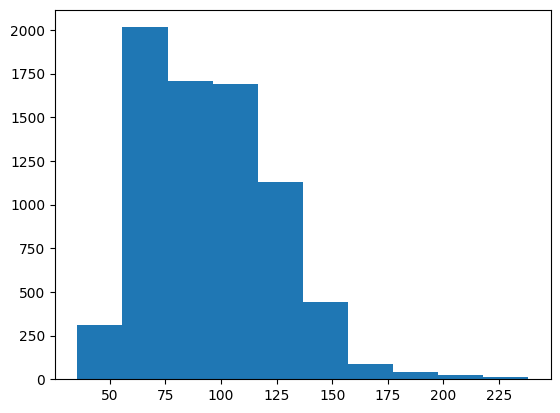

In [40]:
plt.hist([x['cumulative_degrees'] for x in grids['pre_winter_2022']])

(array([  91., 1629., 3824.,  853.,  654.,  275.,   43.,   36.,   41.,
           6.]),
 array([17. , 19.4, 21.8, 24.2, 26.6, 29. , 31.4, 33.8, 36.2, 38.6, 41. ]),
 <BarContainer object of 10 artists>)

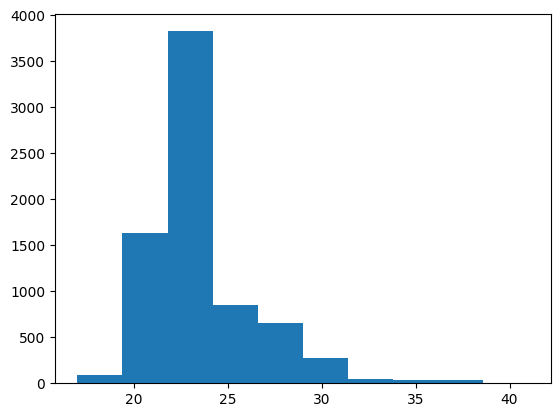

In [41]:
plt.hist([x['dev_days'] for x in grids['pre_winter_2022']])

In [42]:
grids

,col,row,grid_id,emergence_1991,reproduction_1991,egg_larva_mortality_1991,pre_winter_1991,wintering_1991,emergence_1992,reproduction_1992,...,emergence_2021,reproduction_2021,egg_larva_mortality_2021,pre_winter_2021,wintering_2021,emergence_2022,reproduction_2022,egg_larva_mortality_2022,pre_winter_2022,wintering_2022
0,1083,184,1083_184,1991-05-01,"{'eggs': 11, 'non_foraging_days': 9, 'precipit...","{'cold_days': 0.09090909090909091, 'hot_days':...","{'mortality': 0.075, 'dev_days': 30, 'cumulati...","{'winter_temp': 2.261392043758389, 'mortality'...",1992-05-18,"{'eggs': 11, 'non_foraging_days': 9, 'precipit...",...,2021-04-11,"{'eggs': 1, 'non_foraging_days': 19, 'precipit...","{'cold_days': 10.0, 'hot_days': 0.0, 'mortalit...","{'mortality': 0.1075, 'dev_days': 43, 'cumulat...","{'winter_temp': 2.87595928985805, 'mortality':...",2022-05-12,"{'eggs': 11, 'non_foraging_days': 9, 'precipit...","{'cold_days': 0.2727272727272727, 'hot_days': ...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 3.3761900672258416, 'mortality..."
1,1084,184,1084_184,1991-04-30,"{'eggs': 10, 'non_foraging_days': 10, 'precipi...","{'cold_days': 0.1, 'hot_days': 0.0, 'mortality...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 2.294743807087816, 'mortality'...",1992-05-18,"{'eggs': 12, 'non_foraging_days': 8, 'precipit...",...,2021-04-11,"{'eggs': 1, 'non_foraging_days': 19, 'precipit...","{'cold_days': 10.0, 'hot_days': 0.0, 'mortalit...","{'mortality': 0.1075, 'dev_days': 43, 'cumulat...","{'winter_temp': 2.942726503554921, 'mortality'...",2022-05-12,"{'eggs': 11, 'non_foraging_days': 9, 'precipit...","{'cold_days': 0.2727272727272727, 'hot_days': ...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 3.4424062657433785, 'mortality..."
2,1085,184,1085_184,1991-04-28,"{'eggs': 13, 'non_foraging_days': 7, 'precipit...","{'cold_days': 1.0, 'hot_days': 0.0, 'mortality...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 2.3114163571316264, 'mortality...",1992-05-16,"{'eggs': 10, 'non_foraging_days': 10, 'precipi...",...,2021-04-11,"{'eggs': 1, 'non_foraging_days': 19, 'precipit...","{'cold_days': 10.0, 'hot_days': 0.0, 'mortalit...","{'mortality': 0.1075, 'dev_days': 43, 'cumulat...","{'winter_temp': 2.8669182482073134, 'mortality...",2022-05-11,"{'eggs': 12, 'non_foraging_days': 8, 'precipit...","{'cold_days': 0.3333333333333333, 'hot_days': ...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 3.4608536882681302, 'mortality..."
3,1086,184,1086_184,1991-04-21,"{'eggs': 9, 'non_foraging_days': 11, 'precipit...","{'cold_days': 2.3333333333333335, 'hot_days': ...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 2.2810565089377075, 'mortality...",1992-05-14,"{'eggs': 9, 'non_foraging_days': 11, 'precipit...",...,2021-04-11,"{'eggs': 1, 'non_foraging_days': 19, 'precipit...","{'cold_days': 9.0, 'hot_days': 0.0, 'mortality...","{'mortality': 0.1075, 'dev_days': 43, 'cumulat...","{'winter_temp': 2.763313027844809, 'mortality'...",2022-05-11,"{'eggs': 13, 'non_foraging_days': 7, 'precipit...","{'cold_days': 0.3076923076923077, 'hot_days': ...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_temp': 3.405440408429614, 'mortality'..."
4,1081,185,1081_185,1991-04-30,"{'eggs': 10, 'non_foraging_days': 10, 'precipi...","{'cold_days': 0.1, 'hot_days': 0.0, 'mortality...","{'mortality': 0.075, 'dev_days': 30, 'cumulati...","{'winter_temp': 2.316050378632634, 'mortality'...",1992-05-18,"{'eggs': 11, 'non_foraging_days': 9, 'precipit...",...,2021-04-10,"{'eggs': 1, 'non_foraging_days': 19, 'precipit...","{'cold_days': 10.0, 'hot_days': 0.0, 'mortalit...","{'mortality': 0.11, 'dev_days': 44, 'cumulativ...","{'winter_temp': 2.828555416676011, 'mortality'...",2022-05-11,"{'eggs': 10, 'non_foraging_days': 10, 'precipi...","{'cold_days': 0.4, 'hot_days': 0.0, 'mortality...","{'mortality': 0.0725, 'dev_days': 29, 'cumulat...","{'winter_t

(array([  91., 1629., 3824.,  853.,  654.,  275.,   43.,   36.,   41.,
           6.]),
 array([17. , 19.4, 21.8, 24.2, 26.6, 29. , 31.4, 33.8, 36.2, 38.6, 41. ]),
 <BarContainer object of 10 artists>)

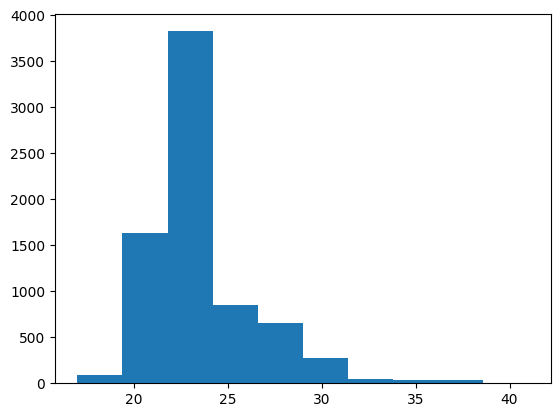

In [43]:
plt.hist([x['dev_days'] for x in grids['pre_winter_2022']])

In [30]:
'''
def runSimulation(years, grids):
    for year in years:
        #grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)
        grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence_vector(x["col"], x["row"], year), axis=1)
        #grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
        grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction_vector(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
        grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortality_vector(x["col"], x["row"], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)
        grids[f"pre_winter_mortality_{year}"] = grids.apply(lambda x: getPreWinteringMortality_vector(x["col"], x["row"], year), axis=1)
        grids[f"winter_mortality_{year}"] = grids.apply(lambda x: getWinteringTemperature_vector(x["col"], x["row"], year), axis=1)

    return grids
'''

'\ndef runSimulation(years, grids):\n    for year in years:\n        #grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)\n        grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence_vector(x["col"], x["row"], year), axis=1)\n        #grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n        grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction_vector(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n        grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortality_vector(x["col"], x["row"], x[f"emergence_{year}"], x[f"reproduction_{year}"]), axis=1)\n        grids[f"pre_winter_mortality_{year}"] = grids.apply(lambda x: getPreWinteringMortality_vector(x["col"], x["row"], year), axis=1)\n        grids[f"winter_mortality_{year}"] = grids.apply(lambda x: getWinteringTemperature_vec

In [31]:
grids.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/emergence_reproduction_13_9C_5mm_adam_November_1991_2022_all_cyle_november_15c.csv', index=False)

In [32]:
######### spatially explicit simulation #########

In [33]:
### spatially explicit model

'''
grids_sp = forage[["col", "row", "grid_id"]]

for year in years:
    grids_sp[f"emergence_{year}"] = grids_sp.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)
    grids_sp[f"reproduction_{year}"] = grids_sp.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
'''

'\ngrids_sp = forage[["col", "row", "grid_id"]]\n\nfor year in years:\n    grids_sp[f"emergence_{year}"] = grids_sp.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)\n    grids_sp[f"reproduction_{year}"] = grids_sp.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n'

In [34]:
#grids_sp.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/spatially_explicit_reproduction_with_max_eggs_with_foraging_quality_5mm_precip_threshold_with_temp_and_forage_scores.csv', index=False)

In [35]:
############ Study Sites ################

In [36]:
'''
sites = ['GreenHouse', "Natalie", 'Mendel', 'Lemont']
lat = [40.802, 40.799, 40.884, 40.808]
lon = [-77.862, -77.905, -77.834, -77.82]

df_sites = pd.DataFrame({
    "site": sites,
    "lat": lat,
    "lon": lon
})


df_st = pd.DataFrame({
    "col": [1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131],
    "row": [219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219],
    "year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
})

df_st["emergence"] = df_st.apply(lambda x: getEmergence(x["col"], x["row"], x["year"]), axis=1)


#df_st["emergence_date"] = pd.to_datetime(df_st["emergence_date"])
#for year in years:
df_st["reproduction"] = df_st.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence"]), axis=1)


df_st["non_foraging_days"] = [x['non_foraging_days'] for x in df_st["reproduction"].tolist()]
df_st["eggs"] = [x['eggs'] for x in df_st["reproduction"].tolist()]
df_st["precipitation_effect"] = [x['precipitation_effect'] for x in df_st["reproduction"].tolist()]
df_st["temperature_effect"] = [x['temperature_effect'] for x in df_st["reproduction"].tolist()]


def getJulianDay(emergence):
    emergence = datetime.strptime(emergence, '%Y-%m-%d').date()
    starting_date = datetime.strptime(f'{emergence.year}-01-01', '%Y-%m-%d').date()
    return (emergence - starting_date).days + 1


df_st["Julian_day"] = df_st["emergence"].apply(lambda x: getJulianDay(str(x)))
'''

'\nsites = [\'GreenHouse\', "Natalie", \'Mendel\', \'Lemont\']\nlat = [40.802, 40.799, 40.884, 40.808]\nlon = [-77.862, -77.905, -77.834, -77.82]\n\ndf_sites = pd.DataFrame({\n    "site": sites,\n    "lat": lat,\n    "lon": lon\n})\n\n\ndf_st = pd.DataFrame({\n    "col": [1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131],\n    "row": [219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219],\n    "year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]\n})\n\ndf_st["emergence"] = df_st.apply(lambda x: getEmergence(x["col"], x["row"], x["year"]), axis=1)\n\n\n#df_st["emergence_date"] = pd.to_datetime(df_st["emergence_date"])\n#for year in years:\ndf_st["reproduction"] = df_st.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence"]), axis=1)\n\n\ndf_st["non_foraging_days"] = [x[\'non_foraging_days\'] for x in df_st["reproduction"].tolist()]\ndf

In [37]:
'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace this with your actual DataFrame)
data = {
    'x': [1, 2, 3, 4, 5],
    'y': [2, 3, 5, 4, 6]
}
df = df_st #pd.DataFrame(data)

columns = ['year', 'non_foraging_days', 'eggs', 'precipitation_effect', 'temperature_effect']
# Scatter plot
i=4
plt.scatter(df['year'], df[columns[i]], label='Number of Cold Days')

# Linear regression
coefficients = np.polyfit(df['year'], df[columns[i]], 1)
slope = coefficients[0]
intercept = coefficients[1]
trendline = f'Regression line: y={slope:.2f}x{intercept:.2f}'
plt.plot(df['year'], intercept + slope * df['year'], color='red', label=trendline)

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Days')
plt.title('Number of Cold (<13.9 C) Days vs Year')
plt.legend()

# Show plot
plt.show()
'''

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Sample DataFrame (replace this with your actual DataFrame)\ndata = {\n    'x': [1, 2, 3, 4, 5],\n    'y': [2, 3, 5, 4, 6]\n}\ndf = df_st #pd.DataFrame(data)\n\ncolumns = ['year', 'non_foraging_days', 'eggs', 'precipitation_effect', 'temperature_effect']\n# Scatter plot\ni=4\nplt.scatter(df['year'], df[columns[i]], label='Number of Cold Days')\n\n# Linear regression\ncoefficients = np.polyfit(df['year'], df[columns[i]], 1)\nslope = coefficients[0]\nintercept = coefficients[1]\ntrendline = f'Regression line: y={slope:.2f}x{intercept:.2f}'\nplt.plot(df['year'], intercept + slope * df['year'], color='red', label=trendline)\n\n# Add labels and legend\nplt.xlabel('Year')\nplt.ylabel('Days')\nplt.title('Number of Cold (<13.9 C) Days vs Year')\nplt.legend()\n\n# Show plot\nplt.show()\n"

In [38]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_st.plot(x='Julian_day', y='temperature_effect', kind='scatter', label='Emergence date')

# Linear regression
coefficients = np.polyfit(df_st['Julian_day'], df_st['temperature_effect'], 1)
slope = coefficients[0]
intercept = coefficients[1]
trendline = f'Regression line: y={slope:.2f}x+{intercept:.2f}'
plt.plot(df_st['Julian_day'], intercept + slope * df_st['Julian_day'], color='red', label=trendline)

# Add labels and legend
plt.xlabel('Julian Date of Emergence')
plt.ylabel('Number of Cold Days')
plt.title('Number of Cold (<13.9 C) Days vs Julian Date of Emergence')
plt.legend()

# Show plot
plt.show()
'''


"\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndf_st.plot(x='Julian_day', y='temperature_effect', kind='scatter', label='Emergence date')\n\n# Linear regression\ncoefficients = np.polyfit(df_st['Julian_day'], df_st['temperature_effect'], 1)\nslope = coefficients[0]\nintercept = coefficients[1]\ntrendline = f'Regression line: y={slope:.2f}x+{intercept:.2f}'\nplt.plot(df_st['Julian_day'], intercept + slope * df_st['Julian_day'], color='red', label=trendline)\n\n# Add labels and legend\nplt.xlabel('Julian Date of Emergence')\nplt.ylabel('Number of Cold Days')\nplt.title('Number of Cold (<13.9 C) Days vs Julian Date of Emergence')\nplt.legend()\n\n# Show plot\nplt.show()\n"